The goal of this project is to predict Airbnb rental price per night in Paris based on the following features: Neighborhood, RoomType, Bathrooms, Bedrooms, GuestsIncluded, MinimumNights, NumberOfReviews, and ReviewScoresRating. The dataset used here was generated by ChatGPT to mimic real data and does not contain actual Airbnb listings.

The model employs neural network and tensorflow to find the optimal parameters (weights and bias). The dataset used in this project is available in the folder and is named "airbnb_listings_paris_realistic.csv". Enjoy reading!

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from google.colab import files
uploaded = files.upload()

Saving airbnb_listings_paris_realistic.csv to airbnb_listings_paris_realistic.csv


In [2]:
#load the dataset

airbnb_data=pd.read_csv("airbnb_listings_paris_realistic.csv")

#features

X_features = ['Neighborhood', 'RoomType', 'Bathrooms', 'Bedrooms', 'GuestsIncluded', 'MinimumNights', 'NumberOfReviews', 'ReviewScoresRating']

#X_train and y_train

X_train=airbnb_data[X_features]
y_train=airbnb_data['Price']

#number of training examples and features

m, n = X_train.shape
print(f"The number of training examples is ={m}")
print(f"The number of features is ={n}")

#show the first 5 training examples

print(f"The first 5 training examples are ={X_train[:2]}")

#show the first 5 target values

print(f"The first 5 target values ={y_train[:2]}")

The number of training examples is =1000
The number of features is =8
The first 5 training examples are =         Neighborhood         RoomType  Bathrooms  Bedrooms  GuestsIncluded  \
0       Latin Quarter  Entire home/apt          3         1               5   
1  6th arrondissement  Entire home/apt          2         2               3   

   MinimumNights  NumberOfReviews  ReviewScoresRating  
0             14              426                  96  
1             10               86                  58  
The first 5 target values =0    277.5
1    337.5
Name: Price, dtype: float64


In [3]:
#some of my data are non numeric, so we must encode them into numbers for the model

X_train_encoded = pd.get_dummies(X_train, columns=['Neighborhood', 'RoomType'])
X_train_encoded=X_train_encoded.astype(int)

m, n = X_train_encoded.shape
print(f"The number of training examples is ={m}")
print(f"The number of features is ={n}")

#show the first 5 training examples after encoding

print(f"The first 5 training examples after encoding are ={X_train_encoded[:2]}")

The number of training examples is =1000
The number of features is =20
The first 5 training examples after encoding are =   Bathrooms  Bedrooms  GuestsIncluded  MinimumNights  NumberOfReviews  \
0          3         1               5             14              426   
1          2         2               3             10               86   

   ReviewScoresRating  Neighborhood_19th arrondissement  \
0                  96                                 0   
1                  58                                 0   

   Neighborhood_1st arrondissement  Neighborhood_20th arrondissement  \
0                                0                                 0   
1                                0                                 0   

   Neighborhood_2nd arrondissement  Neighborhood_6th arrondissement  \
0                                0                                0   
1                                0                                1   

   Neighborhood_7th arrondissement  Neighborhoo

Text(0, 0.5, 'Price')

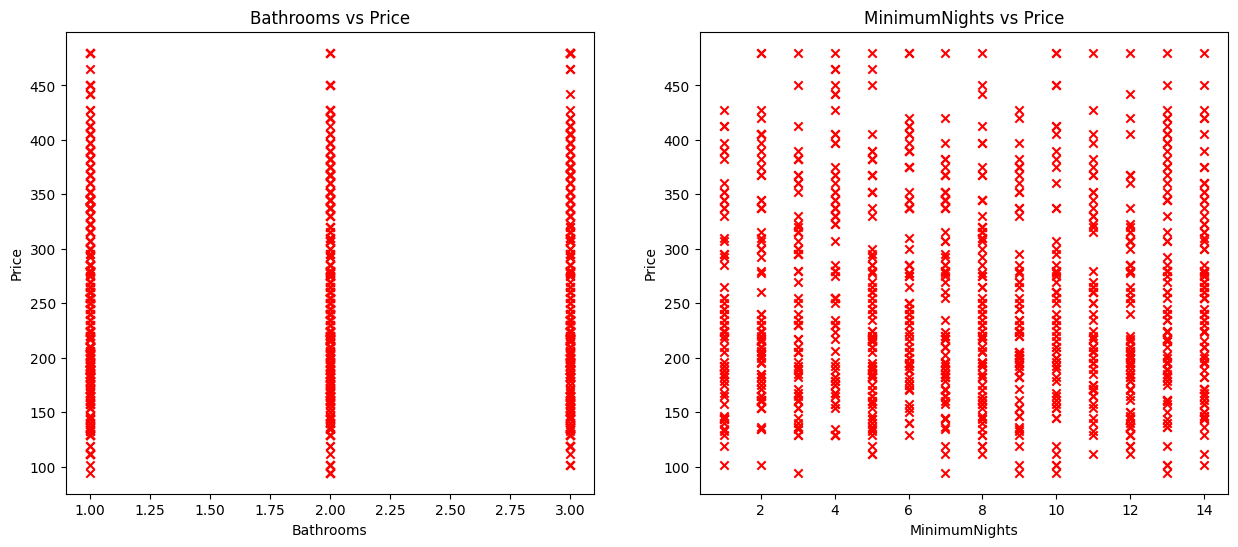

In [4]:
# Let's plot the data to see what they look like
#only few features are plotted

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].scatter(X_train_encoded["Bathrooms"], y_train, marker='x', c='r')
axes[0].set_title("Bathrooms vs Price")
axes[0].set_xlabel("Bathrooms")
axes[0].set_ylabel("Price")

axes[1].scatter(X_train_encoded["MinimumNights"], y_train, marker='x', c='r')
axes[1].set_title("MinimumNights vs Price")
axes[1].set_xlabel("MinimumNights")
axes[1].set_ylabel("Price")

In [5]:
#Let us normalize the data since they are not all of the same scale

def z_normalization(X):
    mu=np.mean(X, axis=0)
    sigma=np.std(X, axis=0)
    X_norm=(X-mu)/sigma
    return X_norm, mu, sigma

In [6]:
X_norm, X_mu, X_sigma=z_normalization(X_train_encoded)
print(f"mu={X_mu}, sigma={X_sigma}, X_norm={X_norm}")

mu=Bathrooms                             2.016
Bedrooms                              2.481
GuestsIncluded                        2.939
MinimumNights                         7.647
NumberOfReviews                     251.892
ReviewScoresRating                   74.987
Neighborhood_19th arrondissement      0.096
Neighborhood_1st arrondissement       0.082
Neighborhood_20th arrondissement      0.076
Neighborhood_2nd arrondissement       0.104
Neighborhood_6th arrondissement       0.083
Neighborhood_7th arrondissement       0.078
Neighborhood_Champs-Élysées           0.097
Neighborhood_Latin Quarter            0.099
Neighborhood_Le Marais                0.099
Neighborhood_Montmartre               0.099
Neighborhood_Saint-Germain            0.087
RoomType_Entire home/apt              0.339
RoomType_Private room                 0.328
RoomType_Shared room                  0.333
dtype: float64, sigma=Bathrooms                             0.817156
Bedrooms                              1.100745
G

Text(0, 0.5, 'Price')

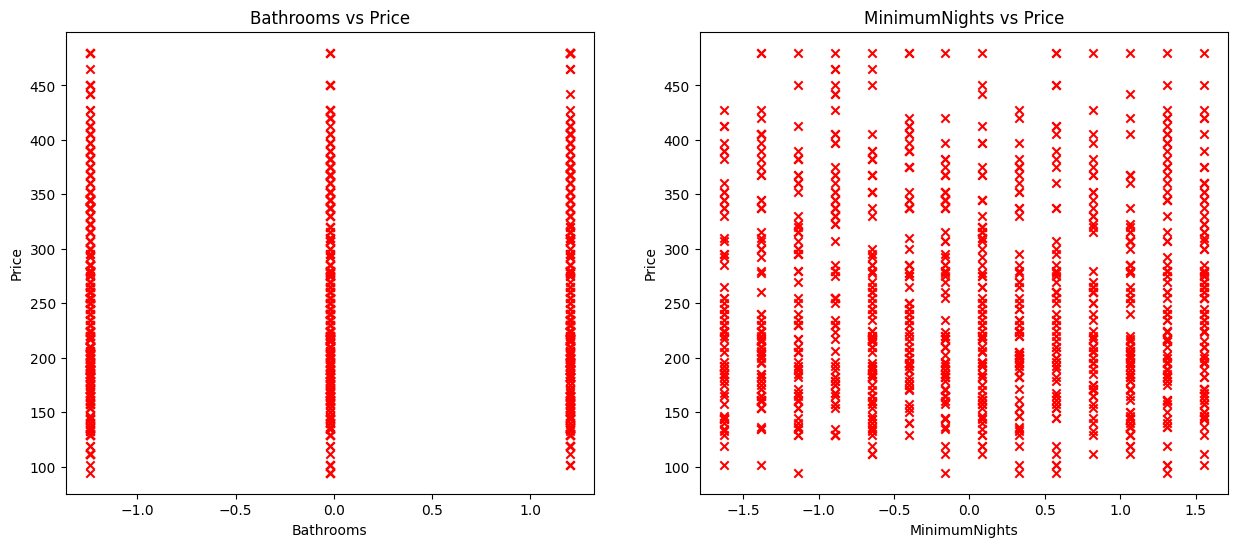

In [7]:
# Let's plot the data to see what they look like
#only few features are plotted

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].scatter(X_norm["Bathrooms"], y_train, marker='x', c='r')
axes[0].set_title("Bathrooms vs Price")
axes[0].set_xlabel("Bathrooms")
axes[0].set_ylabel("Price")

axes[1].scatter(X_norm["MinimumNights"], y_train, marker='x', c='r')
axes[1].set_title("MinimumNights vs Price")
axes[1].set_xlabel("MinimumNights")
axes[1].set_ylabel("Price")


In [8]:
#Let us split the data into the data that will be used for training, cross validation and test.

X_norm_train, X_norm_, y_train1, y_train_ = train_test_split(X_norm,y_train,test_size=0.50, random_state=1)

X_norm_cv, X_norm_test, y_train_cv, y_train_test = train_test_split(X_norm_,y_train_,test_size=0.30, random_state=1)

print("X_norm_train.shape:", X_norm_train.shape, "X_norm_cv.shape:", X_norm_cv.shape, "X_norm_test.shape:", X_norm_test.shape)

print("y_train1.shape:", y_train1.shape, "y_train_cv.shape:", y_train_cv.shape, "y_train_test.shape:", y_train_test.shape)

X_norm_train.shape: (500, 20) X_norm_cv.shape: (350, 20) X_norm_test.shape: (150, 20)
y_train1.shape: (500,) y_train_cv.shape: (350,) y_train_test.shape: (150,)


In [9]:
model=Sequential(
    [
        Dense(10, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1), name="layer1"),
        Dense(10, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1), name="layer2"),
        Dense(5, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1), name="layer3"),
        Dense(1, activation="relu", name="outputlayer")
    ], name="test1"
)

In [10]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [11]:
model.fit(
    X_norm_train, y_train1,
    epochs=200,
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 72012.7578
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 66660.1172
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 41906.3164
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7282.7144
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3567.7307
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1290.2650
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1039.3623
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 756.6456
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 575.2740
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 477.2120
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 447.8401
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 407.9348
Epoch 13/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 328.3573 
Epoch 14/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 300.5827 
Epoch 15/200
16/16 ━━━━━━━━━━━━

In [12]:
model.summary()

Model: "test1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputlayer (Dense)             │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,145 (4.48 KB)

 Trainable params: 381 (1.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 764 (2.99 KB)

In [13]:
#Let us use the training data to predict the output

y_predict=model.predict(X_norm_cv)
#print(f"y_predict: {y_predict}")

#Compute the training error as well as the Cross validation error

training_err = mean_squared_error(y_train1, model.predict(X_norm_train))
cv_err = mean_squared_error(y_train_cv, model.predict(X_norm_cv))
print(f"training error: {training_err:0.3f}")
print(f"cross validation error: {cv_err:0.3f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
training error: 0.980
cross validation error: 2.424


In [14]:
#Compute the test error

test_err = mean_squared_error(y_train_test, model.predict(X_norm_test))
print(f"test error: {test_err:0.3f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
test error: 2.314


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Text(0, 0.5, 'Price')

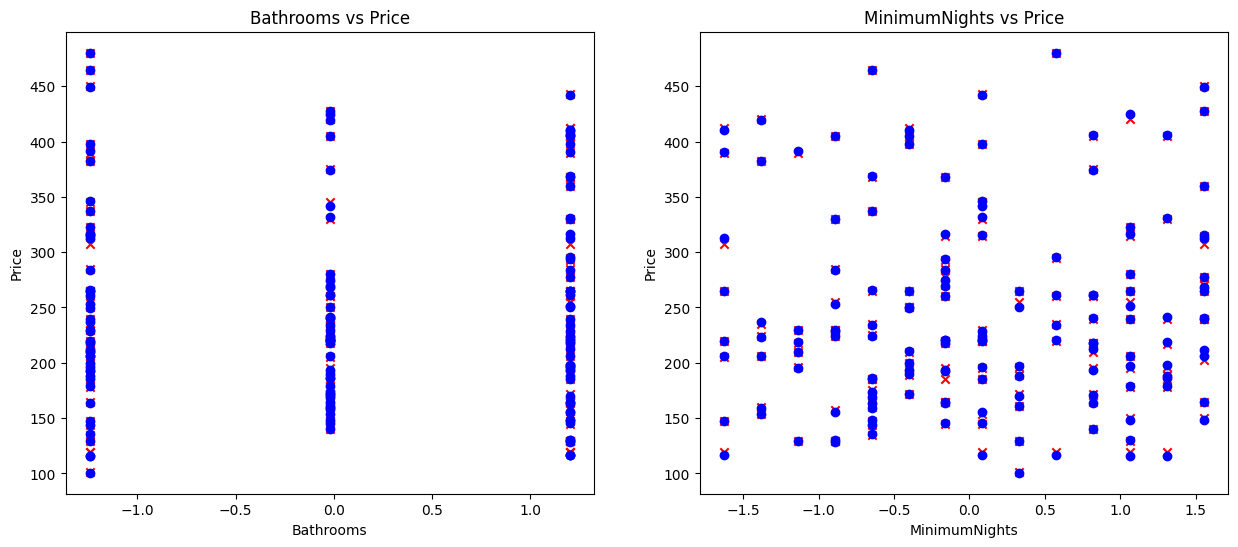

In [15]:
# Let's plot the test data to see what they look like

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].scatter(X_norm_test["Bathrooms"], y_train_test, marker='x', c='r')
axes[0].scatter(X_norm_test["Bathrooms"], model.predict(X_norm_test), marker='o', c='b')
axes[0].set_title("Bathrooms vs Price")
axes[0].set_xlabel("Bathrooms")
axes[0].set_ylabel("Price")

axes[1].scatter(X_norm_test["MinimumNights"], y_train_test, marker='x', c='r')
axes[1].scatter(X_norm_test["MinimumNights"], model.predict(X_norm_test), marker='o', c='b')
axes[1].set_title("MinimumNights vs Price")
axes[1].set_xlabel("MinimumNights")
axes[1].set_ylabel("Price")

For an Airbnb in the '6th arrondissement', 'Private room',  1'Bathrooms', 1'Bedrooms', 2'GuestsIncluded', 4'MinimumNights', 100'NumberOfReviews', 80'ReviewScoresRating' the model predicts the price as follows:

In [16]:
new_data = pd.DataFrame([{
    "Neighborhood": "6th arrondissement",
    "RoomType": "Private room",
    "Bathrooms": 1,
    "Bedrooms": 1,
    "GuestsIncluded": 2,
    "MinimumNights": 4,
    "NumberOfReviews": 100,
    "ReviewScoresRating": 80
}])

In [17]:
#encode

new_data_encoded = pd.get_dummies(new_data, columns=['Neighborhood', 'RoomType'])
new_data_encoded = new_data_encoded.astype(int)

# Reindex to match training columns

new_data_encoded = new_data_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
print(f"new_data_encoded={new_data_encoded}")

# Now scale

new_data_scaled = (new_data_encoded-X_mu)/X_sigma
print(f"new_data_scaled={new_data_scaled}")


# Predict with trained weights

f_predict_new_data=model.predict(new_data_scaled)

# Print result

print(f"An Airbnb in the '6th arrondissement', 'Private room',  1'Bathrooms', 1'Bedrooms', 2'GuestsIncluded', 4'MinimumNights', 100'NumberOfReviews', 80'ReviewScoresRating' will cost around {f_predict_new_data} euros per night")

new_data_encoded=   Bathrooms  Bedrooms  GuestsIncluded  MinimumNights  NumberOfReviews  \
0          1         1               2              4              100   

   ReviewScoresRating  Neighborhood_19th arrondissement  \
0                  80                                 0   

   Neighborhood_1st arrondissement  Neighborhood_20th arrondissement  \
0                                0                                 0   

   Neighborhood_2nd arrondissement  Neighborhood_6th arrondissement  \
0                                0                                1   

   Neighborhood_7th arrondissement  Neighborhood_Champs-Élysées  \
0                                0                            0   

   Neighborhood_Latin Quarter  Neighborhood_Le Marais  \
0                           0                       0   

   Neighborhood_Montmartre  Neighborhood_Saint-Germain  \
0                        0                           0   

   RoomType_Entire home/apt  RoomType_Private room  RoomType